# Reinforcement Learning: Monte Carlo Prediction 

very kindly version

# Google Drive와 연동하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 본인의 파일 저장 경로로 변경해주세요
%cd /content/drive/MyDrive/'Colab Notebooks'/RL2023/MC
!ls
import sys; sys.path.append('..') # add project root to the python path
import numpy as np
import matplotlib.pyplot as plt
from gridworld import *

np.random.seed(0)

/content/drive/MyDrive/Colab Notebooks/RL2023/MC
gridworld.py  MC_Practice_.ipynb


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [4]:
nx, ny = 5, 5
env = GridworldEnv([ny, nx])

/usr/local/lib/python3.9/dist-packages/gym/utils/seeding.py:41: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


def get_action(state): 현재 state에서 action을 정의하는 함수. 본 예제에서는 uniform random 으로 정의합니다. (즉, 모든 방향의 확률이 동일함)

In [5]:
def get_action(state):

        action = np.random.choice(range(4))

        return action

###  `run_episode()`

MC 기법은 하나의 에피소드가 진행되고 state,action,reward 정보를 모두 모아 반환합니다.


In [6]:
def run_episode(env, timeout=1000):
    env.reset()
    states = []
    actions = []
    rewards = []

    i = 0
    timeouted = False
    while True:
        state = env.s
        action = get_action(state)
        next_state, reward, done, info = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        if done:
            break
        else:
            i += 1
            if i >= timeout:
                timeouted = True
                break

    if not timeouted:
        episode = (states, actions, rewards)
    return episode

no_episode 개를 생성하여 episodes 에 저장합니다.

기본 1000개이지만 샘플 숫자를 바꿔가면서 해보세요.

In [7]:
episodes=[]
no_episode = 10000
for _ in range(no_episode):
    episodes.append(run_episode(env))

에피소드의 형식 및 transit이 궁금하면 아래의 코드를 실행해보세요

episode는 s1, a1, r1, s2, a2, r2... 순으로 저장되어 있습니다.

In [8]:
#  episodes 는 list 이므로, len으로 크기 확인
print(len(episodes))
# 10개만 출력해봅시다
print(episodes[1:10])

10000
[([12, 11, 12, 7, 6, 5, 5, 5, 6, 5, 6, 11, 6, 5, 10, 5], [3, 1, 0, 3, 3, 3, 3, 1, 3, 1, 2, 0, 3, 2, 0, 0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]), ([1, 1, 6, 7, 12, 11, 10, 15, 10, 11, 12, 13, 14, 9, 9, 4, 3, 3, 2, 3, 8, 7, 6, 1, 6, 5], [0, 2, 1, 2, 3, 3, 2, 0, 1, 1, 1, 1, 0, 1, 0, 3, 0, 3, 1, 2, 3, 3, 0, 2, 3, 0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]), ([21, 22, 21, 22, 21, 20, 20, 20, 15, 16, 17, 18, 17, 12, 11, 16, 11, 10, 10, 15, 15, 20, 20, 15, 20, 15, 10, 5, 6, 7, 12, 7, 2, 3, 2, 2, 3, 8, 13, 12, 7, 8, 9, 8, 9, 9, 8, 13, 12, 11, 16, 21, 20, 15, 20, 20, 21, 16, 17, 22, 17, 16, 11, 16, 11, 10, 10, 5, 5], [1, 3, 1, 3, 3, 2, 3, 0, 1, 1, 1, 3, 0, 3, 2, 0, 3, 3, 2, 3, 2, 3, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 3, 0, 1, 2, 2, 3, 0, 1, 1, 3, 1, 1, 3, 2, 3, 3, 2, 2, 3, 0, 2, 3, 1, 0, 1, 2, 0, 3, 0, 2, 0, 3, 3, 

# MC
$$V(s) \leftarrow \frac{S(s)}{N(s)}$$
$$Q(s,a) \leftarrow \frac{S(s,a)}{N(s,a)}$$

$S(s)$ : 상태 s 에 대한 return들의 합 \\
$N(s)$ : 상태 s 를 방문한 횟수 \\
$S(s,a)$ : 상태 s에서 a 행동을 했을 때 return들의 값 \\
$N(s,a)$ : 상태 s에서 a 행동을 한 횟수

Every Visit 방식입니다.

In [9]:
s_v = np.zeros(shape=nx*ny)
s_q = np.zeros(shape=(nx*ny,4))
n_v = np.zeros(shape=nx*ny)
n_q = np.zeros(shape=(nx*ny,4))
gamma = 1.0
lr = 1e-3

for episode in episodes:
    states, actions, rewards = episode

    # reversing the inputs! (뒤에서 부터 계산하기 위함)
    # for efficient computation of returns
    states = reversed(states)
    actions = reversed(actions)
    rewards = reversed(rewards)

    iter = zip(states, actions, rewards)
    cum_r = 0
    for s, a, r in iter:
        cum_r *= gamma
        cum_r += r

        n_v[s] += 1 # counting
        n_q[s, a] += 1

        s_v[s] += cum_r 
        s_q[s, a] += cum_r
v = s_v / (n_v)
q = s_q / (n_q)

## 추산된 상태가치함수 $V(s)$ 및 $Q(s,a)$ 확인하기

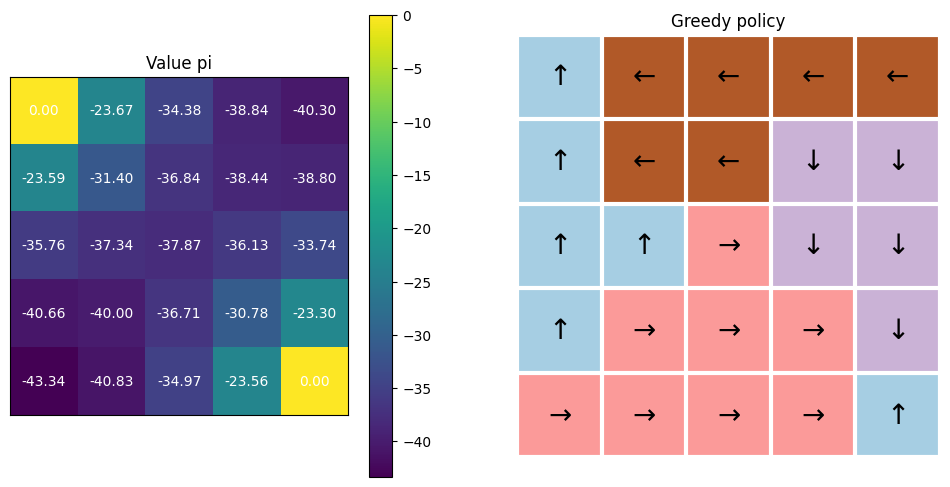

In [10]:
# sample이 많아지면 정답과 가까워진다
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], q, nx, ny)
_ = ax[1].set_title("Greedy policy")

In [11]:
import pandas as pd

def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def visualize_q(q):
    df = pd.DataFrame(q, columns=['up', 'right', 'down', 'left']).T
    df = df.style.apply(highlight_max)
    return df
df = visualize_q(q)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
up,0.000000,-25.062553,-35.861437,-40.700277,-41.372685,-1.000000,-25.399173,-35.456909,-39.696347,-41.179180,-24.472046,-33.095450,-38.436108,-39.281216,-39.530437,-37.138195,-38.205935,-38.328146,-38.107269,-34.386536,-42.057580,-41.100326,-38.220746,-30.801218,0.000000
right,0.000000,-36.944661,-40.095457,-41.541571,-41.256946,-32.394558,-38.175101,-40.214188,-40.453587,-39.594983,-39.639896,-39.065008,-37.041745,-34.850788,-34.195556,-40.545248,-37.589886,-31.772727,-23.390220,-24.975979,-41.819645,-35.969925,-24.393165,-1.000000,0.000000
down,0.000000,-31.778441,-37.950786,-39.186052,-39.485248,-36.331496,-37.273512,-39.441014,-36.600052,-35.358994,-41.693483,-40.867017,-37.771763,-31.677445,-24.219754,-43.646084,-42.326942,-35.110278,-24.475260,-1.000000,-44.866035,-41.880424,-36.132283,-24.915879,0.000000
left,0.000000,-1.000000,-23.763416,-34.095507,-39.089556,-24.205856,-25.173554,-32.222101,-37.005764,-39.018448,-37.243825,-36.299919,-38.220631,-38.855964,-36.907702,-41.241589,-41.859141,-41.442231,-36.957696,-32.745391,-44.648031,-44.571393,-41.065612,-37.018676,0.000000


## Incremental MC (Mission)


$$V(s) \leftarrow V(s) + \alpha (G(s) - V(s))$$
$$Q(s,a) \leftarrow Q(s,a) + \alpha (G(s,a) - Q(s,a))$$

$\alpha$: learning rate \\
$G(s)$:상태 s에서의 return \\
$G(s,a)$: 상태 s, 행동 a에서의 return

alpha = 값을 정의한 후 incremental MC 방식으로 v(s)와 q(s,a)의 값을 계산해보세요

In [14]:
v = np.zeros(shape=nx*ny)
q = np.zeros(shape=(nx*ny,4))
gamma = 1.0
alpha = 1e-3

for episode in episodes:
    states, actions, rewards = episode

    # reversing the inputs! (뒤에서 부터 계산하기 위함)
    # for efficient computation of returns
    states = reversed(states)
    actions = reversed(actions)
    rewards = reversed(rewards)

    iter = zip(states, actions, rewards)
    cum_r = 0
    for s, a, r in iter:
        cum_r *= gamma
        cum_r += r

        v[s] += alpha * (cum_r - v[s])
        q[s, a] += alpha * (cum_r - q[s, a])

## 추산된 상태가치함수 $V(s)$ 및 $Q(s,a)$ 확인하기

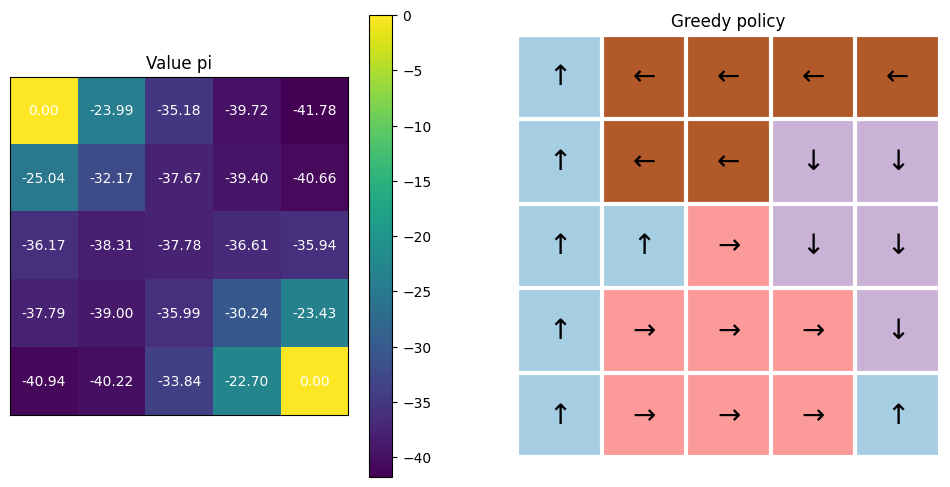

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], q, nx, ny)
_ = ax[1].set_title("Greedy policy")

In [16]:
import pandas as pd

def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def visualize_q(q):
    df = pd.DataFrame(q, columns=['up', 'right', 'down', 'left']).T
    df = df.style.apply(highlight_max)
    return df
df = visualize_q(q)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
up,0.000000,-23.542063,-34.312001,-39.104115,-40.136254,-0.900853,-24.926128,-34.896810,-38.459950,-39.711593,-24.958939,-32.385893,-37.423055,-38.401121,-38.339497,-36.369782,-37.764370,-37.244813,-36.939937,-31.310821,-40.672025,-40.561756,-37.164704,-27.091599,0.000000
right,0.000000,-33.745176,-38.814238,-40.618563,-40.496248,-29.656791,-37.081436,-39.300655,-39.998641,-40.051406,-38.721862,-38.560017,-36.299076,-34.015540,-34.422784,-38.075498,-36.651858,-30.838414,-22.645843,-22.294068,-41.006221,-34.583895,-22.691612,-0.897730,0.000000
down,0.000000,-29.379973,-37.846169,-37.539026,-38.733525,-33.097907,-36.238164,-38.330774,-35.696425,-35.292973,-40.360100,-39.514523,-36.916974,-31.839192,-23.726524,-42.694208,-40.837837,-33.545232,-22.785053,-0.894719,-42.797510,-41.161656,-35.068237,-22.307391,0.000000
left,0.000000,-0.903689,-23.221930,-33.918610,-38.189536,-22.353064,-23.971208,-32.095059,-36.081537,-38.745456,-36.245045,-36.826900,-37.425079,-37.668303,-36.194277,-39.060771,-40.384313,-40.745622,-34.898927,-29.383286,-43.016713,-43.299864,-39.275339,-33.248927,0.000000
